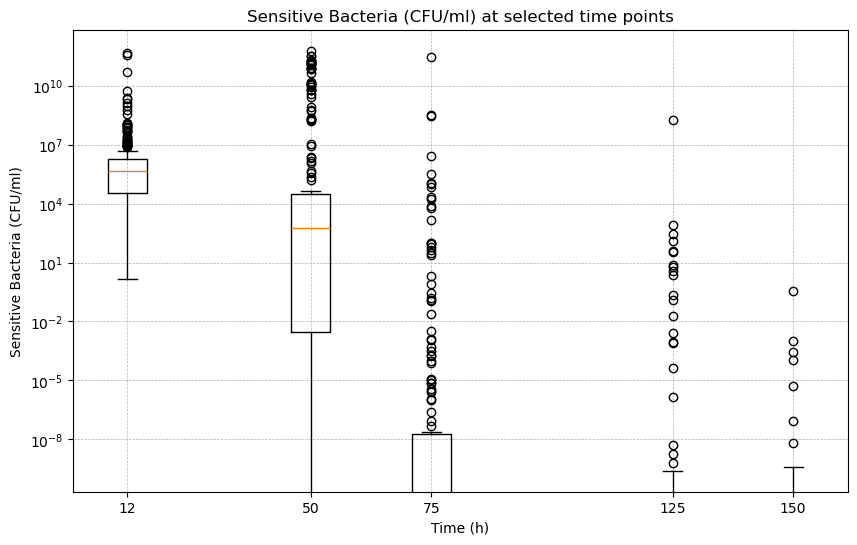

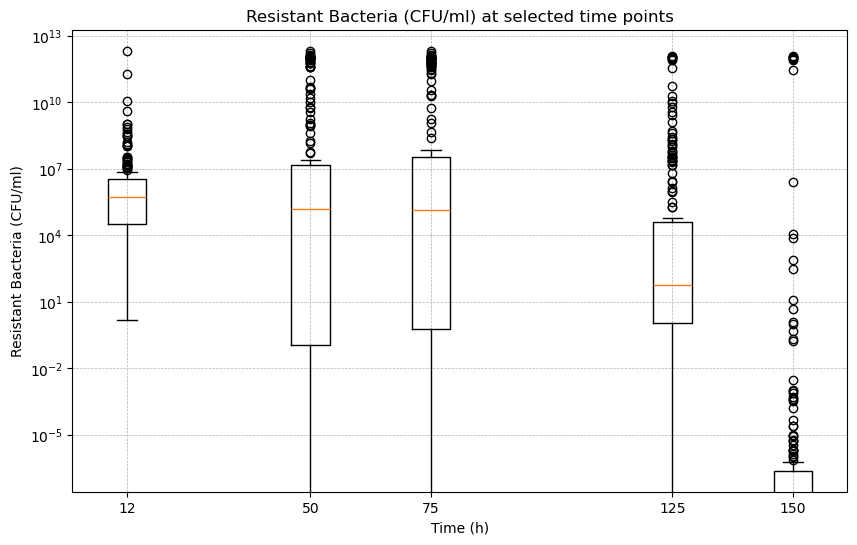

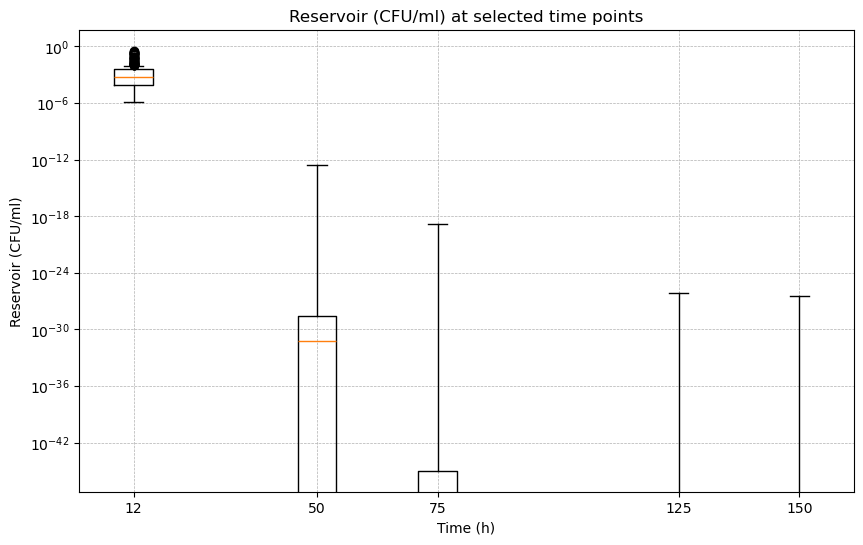

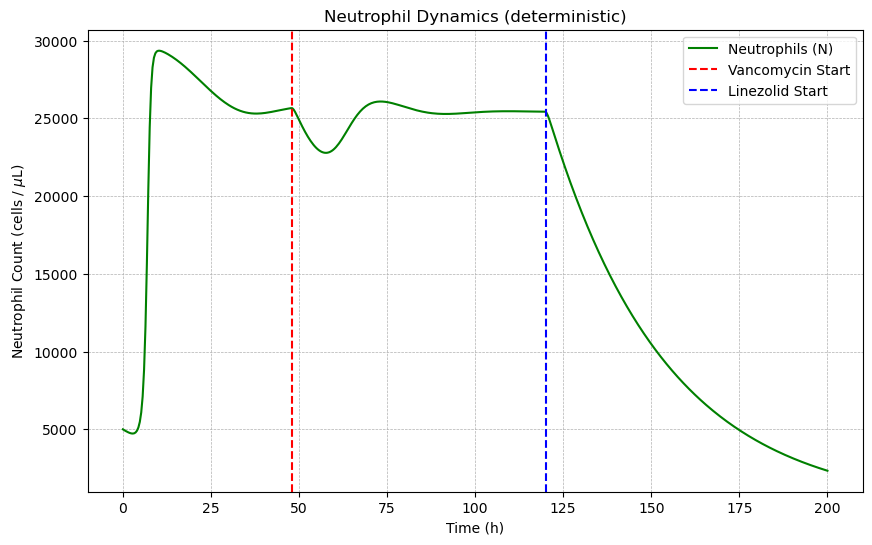

In [11]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# -------------------- Pharmacokinetic Model --------------------
class PharmacokineticModel:
    def __init__(self):
        # Vancomycin
        self.van_dose = 1200
        self.van_interval = 6
        self.van_duration = 72
        self.van_ke = 0.173
        self.van_volume = 50
        # Linezolid
        self.lzd_dose = 800
        self.lzd_interval = 12
        self.lzd_duration = 192
        self.lzd_ke = 0.116
        self.lzd_volume = 45

    def calculate_concentrations(self, drug_type, total_time_h, start_h=0):
        if drug_type == "vancomycin":
            dose, interval, duration, ke, volume = self.van_dose, self.van_interval, self.van_duration, self.van_ke, self.van_volume
        else:
            dose, interval, duration, ke, volume = self.lzd_dose, self.lzd_interval, self.lzd_duration, self.lzd_ke, self.lzd_volume

        t = np.linspace(0, total_time_h, int(total_time_h*10)+1)
        conc = np.zeros_like(t)
        for dt in np.arange(start_h, start_h+duration, interval):
            mask = t >= dt
            conc[mask] += (dose / volume) * np.exp(-ke*(t[mask]-dt))
        conc[t < start_h] = 0
        return t, conc

# -------------------- Immune Response --------------------
class ImmuneResponse:
    def __init__(self, rho_N=1e-6, N_MAX=30000, delta_N=0.03, kill_N=5e-5):
        self.rho_N = rho_N
        self.N_MAX = N_MAX
        self.delta_N = delta_N
        self.kill_N = kill_N

    def compute(self, N, A_total):
        dN = self.rho_N * N * A_total * (1 - N/self.N_MAX) - self.delta_N * N
        immune_effect = self.kill_N * N
        return dN, immune_effect

# -------------------- ODE System --------------------
def immune_and_pd_model(y, t, params, van_func, lzd_func, immune_model):
    S, R, A_res, N = y
    V = max(0, van_func(t))
    L = max(0, lzd_func(t))

    S, R, A_res = max(S,0), max(R,0), max(A_res,0)  # bacteria clipped
    A_total = S + R + A_res

    h_V = h_L = 1
    linezolid_inhibition = (params['Emax_l'] * L**h_L) / (params['EC50_L']**h_L + L**h_L)
    vancomycin_kill = (params['Emax_v'] * V**h_V) / (params['EC50_V']**h_V + V**h_V)
    logistic = (1 - A_total / params['B_max'])

    dN, immune_effect = immune_model.compute(N, A_total)
    immune_S = immune_effect * S
    immune_R = immune_effect * R
    immune_Ares = immune_effect * A_res

    dS = params['rho_S']*S*logistic - params['delta']*S - immune_S - vancomycin_kill*S - linezolid_inhibition*S
    dR = params['rho_R']*R*logistic - params['delta']*R - immune_R - linezolid_inhibition*R + params['f_r_b']*A_res - params['f_b_r']*R
    dA_res = (params['rho_res']*A_res*(1-A_res/params['k_res']) - params['delta_res']*A_res - params['f_r_b']*A_res - immune_Ares)

    return [dS, dR, dA_res, dN]

# -------------------- Base Parameters --------------------
base_params = {
    'rho_S':1.47, 'rho_R':1.47, 'B_max':4e12, 'delta':0.179,
    'Emax_v':1.74, 'Emax_l':1.97, 'EC50_V':0.245, 'EC50_L':0.56,
    'rho_res':0.1, 'k_res':1e4, 'delta_res':0.1, 'f_r_b':0.02, 'f_b_r':0.02
}

def sample_parameters(base_params, sigma=0.3):
    sampled_params = {}
    for k, v in base_params.items():
        if k not in ['B_max','k_res']:
            mu = np.log(v) - 0.5 * sigma**2
            sampled_params[k] = np.random.lognormal(mean=mu, sigma=sigma)
        else:
            sampled_params[k] = v
    return sampled_params

# -------------------- Simulation Setup --------------------
total_h = 200
pk = PharmacokineticModel()
immune_model = ImmuneResponse()
vanco_start = 48
lzd_start = vanco_start + pk.van_duration

t_van, conc_van = pk.calculate_concentrations('vancomycin', total_h, vanco_start)
t_lzd, conc_lzd = pk.calculate_concentrations('linezolid', total_h, lzd_start)
van_func = interp1d(t_van, conc_van, bounds_error=False, fill_value=0)
lzd_func = interp1d(t_lzd, conc_lzd, bounds_error=False, fill_value=0)

y0 = [1e3, 1e3, 1e1, 5000]
t_eval = np.linspace(0, total_h, 500)

# -------------------- Monte Carlo for bacteria --------------------
n_sims = 200
results = []

for _ in range(n_sims):
    sampled = sample_parameters(base_params, sigma=0.3)
    sol = odeint(immune_and_pd_model, y0, t_eval, args=(sampled, van_func, lzd_func, immune_model))
    results.append(sol)

results = np.stack(results, axis=0)  # shape: (n_sims, n_timepoints, n_variables)

# -------------------- Boxplots at selected time points --------------------
#time_points_h = [12, 50, 75, 125, 150]  # hours
time_points = 50
indices = [np.argmin(np.abs(t_eval - tp)) for tp in time_points_h]

def plot_boxplots(data, var_index, label):
    box_data = [data[:, idx, var_index] for idx in indices]
    plt.figure(figsize=(10,6))
    plt.boxplot(box_data, positions=time_points_h, widths=8)
    plt.yscale("log")
    plt.xlabel("Time (h)")
    plt.ylabel(label)
    plt.title(f"{label} at selected time points")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.show()

plot_boxplots(results, 0, "Sensitive Bacteria (CFU/ml)")
plot_boxplots(results, 1, "Resistant Bacteria (CFU/ml)")
plot_boxplots(results, 2, "Reservoir (CFU/ml)")

# -------------------- Deterministic neutrophils --------------------
deterministic = odeint(immune_and_pd_model, y0, t_eval, args=(base_params, van_func, lzd_func, immune_model))
plt.figure(figsize=(10,6))
plt.plot(t_eval, deterministic[:,3], color="green", label="Neutrophils (N)")
plt.axvline(vanco_start, color="red", linestyle="--", label="Vancomycin Start")
plt.axvline(lzd_start, color="blue", linestyle="--", label="Linezolid Start")
plt.xlabel("Time (h)")
plt.ylabel(r"Neutrophil Count (cells / $\mu$L)")
plt.title("Neutrophil Dynamics (deterministic)")
plt.grid(True, ls="--", lw=0.5)
plt.legend()
plt.show()


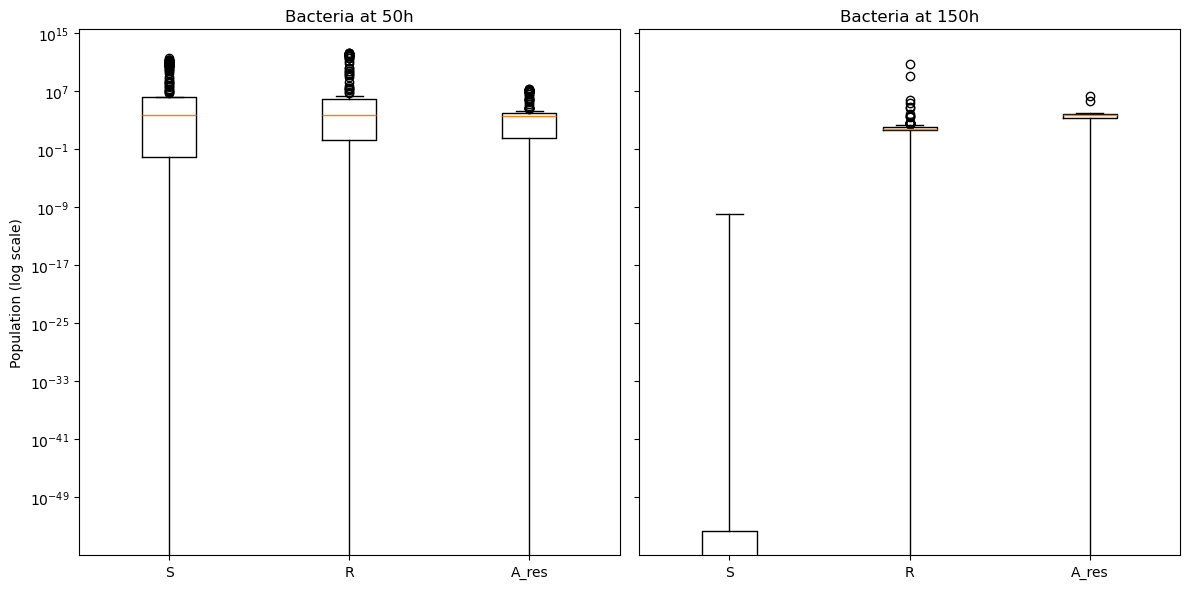

In [13]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- Pharmacokinetic Model ---
class PharmacokineticModel:
    def __init__(self):
        # Vancomycin
        self.van_dose = 1200
        self.van_interval = 6
        self.van_duration = 72
        self.van_ke = 0.173
        self.van_volume = 50
        # Linezolid
        self.lzd_dose = 800
        self.lzd_interval = 12
        self.lzd_duration = 192
        self.lzd_ke = 0.116
        self.lzd_volume = 45

    def concentration_function(self, drug_type, total_time_h, start_h=0):
        if drug_type == 'vancomycin':
            dose, interval, duration, ke, volume = (
                self.van_dose, self.van_interval, self.van_duration,
                self.van_ke, self.van_volume
            )
        else:
            dose, interval, duration, ke, volume = (
                self.lzd_dose, self.lzd_interval, self.lzd_duration,
                self.lzd_ke, self.lzd_volume
            )

        t_points = np.linspace(0, total_time_h, int(total_time_h*10)+1)
        conc = np.zeros_like(t_points)
        for dt in np.arange(start_h, start_h + duration, interval):
            mask = t_points >= dt
            conc[mask] += (dose/volume) * np.exp(-ke*(t_points[mask]-dt))
        conc[t_points < start_h] = 0

        def conc_func(t):
            return np.interp(t, t_points, conc)
        return conc_func

# --- Immune Response Model ---
class ImmuneResponse:
    def __init__(self, rho_N=1e-6, N_MAX=30000, delta_N=0.03,
                 kill_N=5e-5, N0=5000):
        self.rho_N = rho_N
        self.N_MAX = N_MAX
        self.delta_N = delta_N
        self.kill_N = kill_N
        self.N0 = N0

    def compute(self, N, A_total, t=None):
        dN = self.rho_N * N * A_total * (1 - N/self.N_MAX) - self.delta_N * N
        immune_effect = self.kill_N * N
        return dN, immune_effect

# --- ODE System ---
def immune_and_pd_model(y, t, params, van_func, lzd_func, immune_model):
    S, R, A_res, N = y
    V = max(0, van_func(t))
    L = max(0, lzd_func(t))
    S, R, A_res, N = max(S,0), max(R,0), max(A_res,0), max(N,0)
    A_total = S + R + A_res

    # Drug effects
    linezolid_inhibition = (params['Emax_l']*L) / (params['EC50_L'] + L)
    vancomycin_kill = (params['Emax_v']*V) / (params['EC50_V'] + V)
    logistic = (1 - A_total / params['B_max'])

    # Immune Response
    dN, immune_effect = immune_model.compute(N, A_total, t)
    immune_S = immune_effect * S
    immune_R = immune_effect * R
    immune_Ares = immune_effect * A_res

    # Dynamics
    dS = (params['rho_S']*S*logistic - params['delta']*S
          - immune_S - vancomycin_kill*S - linezolid_inhibition*S)
    dR = (params['rho_R']*R*logistic - params['delta']*R
          - immune_R - linezolid_inhibition*R
          + params['f_r_b']*A_res - params['f_b_r']*R)
    dA_res = (params['rho_res']*A_res*(1-A_res/params['k_res'])
              - params['delta_res']*A_res
              - params['f_r_b']*A_res + params['f_b_r']*R
              - immune_Ares)

    return [dS, dR, dA_res, dN]

# --- Base Params ---
base_params = {
    'rho_S':1.47, 'rho_R':1.47, 'B_max':4e12, 'delta':0.179,
    'Emax_v':1.74, 'Emax_l':1.97, 'EC50_V':0.245, 'EC50_L':0.56,
    'rho_res':1.47, 'k_res':1e4, 'delta_res':0.179,
    'f_r_b':0.02, 'f_b_r':0.02
}

# --- Monte Carlo Parameter Sampling ---
def sample_parameters(base_params, sigma=0.3):
    sampled = {}
    for k,v in base_params.items():
        if k not in ['B_max','k_res']:  # keep these deterministic
            mu = np.log(v) - 0.5 * sigma**2
            sampled[k] = np.random.lognormal(mean=mu, sigma=sigma)
        else:
            sampled[k] = v
    return sampled

# --- Run Simulation ---
def run_single(params, total_h=300):
    pk = PharmacokineticModel()
    immune_model = ImmuneResponse(N0=5000)

    vanco_start = 48
    lzd_start = vanco_start + pk.van_duration
    van_func = pk.concentration_function('vancomycin', total_h, vanco_start)
    lzd_func = pk.concentration_function('linezolid', total_h, lzd_start)

    y0 = [1e3, 1e3, 1e1, immune_model.N0]
    t_eval = np.linspace(0, total_h, 500)
    sol = odeint(immune_and_pd_model, y0, t_eval,
                 args=(params, van_func, lzd_func, immune_model))
    return t_eval, sol

# --- Monte Carlo Loop ---
n_sims = 200
results_50 = []
results_150 = []

for i in range(n_sims):
    p = sample_parameters(base_params, sigma=0.3)
    t_eval, sol = run_single(p)
    # Find values at 50h and 150h
    idx_50 = np.argmin(np.abs(t_eval - 50))
    idx_150 = np.argmin(np.abs(t_eval - 150))
    results_50.append(sol[idx_50, :3])   # S, R, A_res
    results_150.append(sol[idx_150, :3]) # S, R, A_res

results_50 = np.array(results_50)
results_150 = np.array(results_150)

# --- Boxplots ---
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

axes[0].boxplot([results_50[:,0], results_50[:,1], results_50[:,2]],
                labels=['S','R','A_res'])
axes[0].set_title("Bacteria at 50h")
axes[0].set_yscale('log')
axes[0].set_ylabel("Population (log scale)")

axes[1].boxplot([results_150[:,0], results_150[:,1], results_150[:,2]],
                labels=['S','R','A_res'])
axes[1].set_title("Bacteria at 150h")
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()
